In [1]:
%matplotlib inline


# 1D spectrum simulation

Simulate a number of spectral on-off observations of a source with a power-law spectral
model using the CTA 1DC response and fit them with the assumed spectral model.

## Prerequisites

-  Knowledge of spectral extraction and datasets used in gammapy, see
   for instance the :doc:`spectral analysis
   tutorial </tutorials/analysis-1d/spectral_analysis>`

## Context

To simulate a specific observation, it is not always necessary to
simulate the full photon list. For many uses cases, simulating directly
a reduced binned dataset is enough: the IRFs reduced in the correct
geometry are combined with a source model to predict an actual number of
counts per bin. The latter is then used to simulate a reduced dataset
using Poisson probability distribution.

This can be done to check the feasibility of a measurement, to test
whether fitted parameters really provide a good fit to the data etc.

Here we will see how to perform a 1D spectral simulation of a CTA
observation, in particular, we will generate OFF observations following
the template background stored in the CTA IRFs.

**Objective: simulate a number of spectral ON-OFF observations of a
source with a power-law spectral model with CTA using the CTA 1DC
response, fit them with the assumed spectral model and check that the
distribution of fitted parameters is consistent with the input values.**

## Proposed approach

We will use the following classes and functions:

-  `~gammapy.datasets.SpectrumDatasetOnOff`
-  `~gammapy.datasets.SpectrumDataset`
-  `~gammapy.irf.load_irf_dict_from_file`
-  `~gammapy.modeling.models.PowerLawSpectralModel`


In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

## Setup




In [3]:
from IPython.display import display
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import Datasets, SpectrumDataset, SpectrumDatasetOnOff
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel

## Check setup



In [4]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /home/born-again/anaconda3/envs/gammapy-1.1/bin/python 
	python_version         : 3.9.18     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.1        
	path                   : /home/born-again/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.24.4     
	scipy                  : 1.10.1     
	astropy                : 5.3.4      
	regions                : 0.7        
	click                  : 8.1.3      
	yaml                   : 6.0.1      
	IPython                : 8.7.0      
	jupyterlab             : 3.5.3      
	matplotlib             : 3.7.3      
	pandas                 : 1.5.2      
	healpy                 : 1.16.6     
	iminuit                : 2.21.3     
	sherpa                 : 4.15.1     
	naima                  : 0.10.0     
	emcee                  : 3.1.3      
	corner                 : 2.2.1      
	r

## Simulation of a single spectrum

To do a simulation, we need to define the observational parameters like
the livetime, the offset, the assumed integration radius, the energy
range to perform the simulation for and the choice of spectral model. We
then use an in-memory observation which is convolved with the IRFs to
get the predicted number of counts. This is Poisson fluctuated using
the `fake()` to get the simulated counts for each observation.




In [6]:
# Define simulation parameters parameters
livetime = 1 * u.h

pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg

# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-0.5, 1.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.2, 2.0, 31), unit="TeV", name="energy_true", interp="log"
)

on_region_radius = Angle("0.11 deg")

center = pointing.directional_offset_by(position_angle=0 * u.deg, separation=offset)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)

# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=3.0,
    amplitude=2.5e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu, name="source")

PowerLawSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 3.0000e+00                ... nan  False   False     
spectral amplitude 2.5000e-12 TeV-1 s-1 cm-2 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     


Load the IRFs
In this simulation, we use the CTA-1DC IRFs shipped with Gammapy.



In [7]:
irfs = load_irf_dict_from_file(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)
print(obs)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.04
	duration          : 3600.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



/home/born-again/anaconda3/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy/data/observations.py:226: GammapyDeprecationWarning: Pointing will be required to be provided as FixedPointingInfo
  warnings.warn(


Simulate a spectra




In [8]:
# Make the SpectrumDataset
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="obs-0"
)
maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])

dataset = maker.run(dataset_empty, obs)

# Set the model on the dataset, and fake
dataset.models = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset
---------------

  Name                            : obs-0 

  Total counts                    : 298 
  Total background counts         : 22.29
  Total excess counts             : 275.71

  Predicted counts                : 303.66
  Predicted background counts     : 22.29
  Predicted excess counts         : 281.37

  Exposure min                    : 2.53e+08 m2 s
  Exposure max                    : 1.77e+10 m2 s

  Number of total bins            : 9 
  Number of fit bins              : 9 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1811.58

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                         :      3.

You can see that background counts are now simulated




### On-Off analysis

To do an on off spectral analysis, which is the usual science case, the
standard would be to use `SpectrumDatasetOnOff`, which uses the
acceptance to fake off-counts. Please also refer to :doc:`simulations in
the absence of a background model
<spectral_analysis_rad_max.html#dataset-simulations>`
for simulations based on observations of real off counts.




In [9]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)
dataset_on_off.fake(npred_background=dataset.npred_background())
print(dataset_on_off)

SpectrumDatasetOnOff
--------------------

  Name                            : qe2rE5wX 

  Total counts                    : 271 
  Total background counts         : 21.00
  Total excess counts             : 250.00

  Predicted counts                : 301.96
  Predicted background counts     : 20.59
  Predicted excess counts         : 281.37

  Exposure min                    : 2.53e+08 m2 s
  Exposure max                    : 1.77e+10 m2 s

  Number of total bins            : 9 
  Number of fit bins              : 9 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 18.12

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                       

You can see that off counts are now simulated as well. We now simulate
several spectra using the same set of observation conditions.




In [10]:
n_obs = 100
datasets = Datasets()

for idx in range(n_obs):
    dataset_on_off.fake(random_state=idx, npred_background=dataset.npred_background())
    dataset_fake = dataset_on_off.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"] = [idx]
    datasets.append(dataset_fake)

table = datasets.info_table()
display(table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
obs-0,317,298.6000061035156,27.08240180813126,18.399999618530273,68.16666751313541,68.16666751313541,nan,252718176.0,17719697408.0,3600.000000000002,3600.000000000002,0.08805555555555551,0.0051111110051472956,0.08294444613986542,9,9,wstat,738.7245834271496,92,9.0,45.0,0.20000000298023224
obs-1,275,253.0,23.76785365487285,22.0,64.16666666666669,64.16666666666669,nan,252718170.9728747,17719697919.59926,3600.000000000002,3600.000000000002,0.07638888888888885,0.006111111111111108,0.07027777777777774,9,9,wstat,575.779512784738,110,9.0,45.0,0.2
obs-2,293,272.4,25.17110555404655,20.6,66.0,66.0,nan,252718170.9728747,17719697919.59926,3600.000000000002,3600.000000000002,0.08138888888888884,0.00572222222222222,0.07566666666666662,9,9,wstat,645.4993824075303,103,9.0,45.0,0.2
obs-3,280,257.6,23.982951737405354,22.4,65.33333333333334,65.33333333333334,nan,252718170.9728747,17719697919.59926,3600.000000000002,3600.000000000002,0.07777777777777774,0.006222222222222218,0.07155555555555553,9,9,wstat,585.9241546985872,112,9.0,45.00000000000001,0.19999999999999998
obs-4,337,316.4,27.682709945184747,20.6,73.33333333333334,73.33333333333334,nan,252718170.9728747,17719697919.59926,3600.000000000002,3600.000000000002,0.09361111111111106,0.00572222222222222,0.08788888888888884,9,9,wstat,787.314723949448,103,9.0,45.0,0.2
obs-5,283,258.6,23.727154782347895,24.400000000000002,67.50000000000001,67.50000000000001,nan,252718170.9728747,17719697919.59926,3600.000000000002,3600.000000000002,0.07861111111111108,0.006777777777777775,0.0718333333333333,9,9,wstat,574.8525737727499,122,9.0,45.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
obs-94,322,300.2,26.574029757473202,21.8,71.83333333333334,71.83333333333334,nan,252718170.9728747,17719697919.59926,3600.000000000002,3600.000000000002,0.0894444444444444,0.006055555555555553,0.08338888888888885,9,9,wstat,715.2570498037147,109,9.0,45.0,0.2


Before moving on to the fit let’s have a look at the simulated
observations.




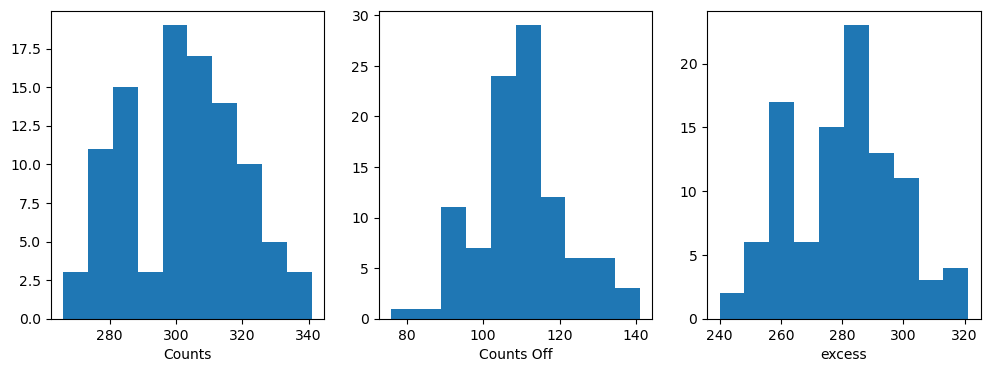

In [11]:
fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(table["counts"])
axes[0].set_xlabel("Counts")
axes[1].hist(table["counts_off"])
axes[1].set_xlabel("Counts Off")
axes[2].hist(table["excess"])
axes[2].set_xlabel("excess")
plt.show()

Now, we fit each simulated spectrum individually




In [12]:
results = []

fit = Fit()

for dataset in datasets:
    dataset.models = model.copy()
    result = fit.optimize(dataset)
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )

We take a look at the distribution of the fitted indices. This matches
very well with the spectrum that we initially injected.




index: 3.0036925550381217 += 0.08081469527619482


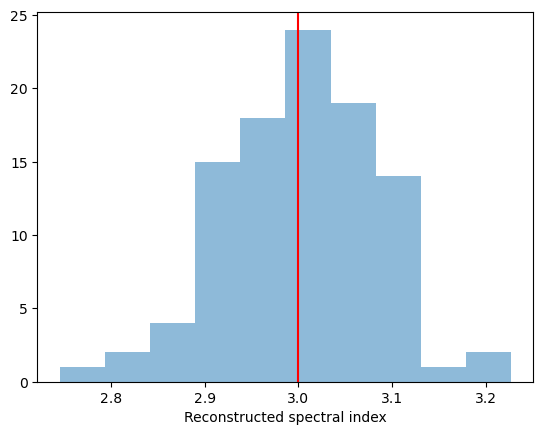

In [13]:
fig, ax = plt.subplots()
index = np.array([_["index"] for _ in results])
ax.hist(index, bins=10, alpha=0.5)
ax.axvline(x=model_simu.parameters["index"].value, color="red")
ax.set_xlabel("Reconstructed spectral index")
print(f"index: {index.mean()} += {index.std()}")
plt.show()

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-0
  Instrument : CTA
  Models     : ['8-c4noJ2']

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-1
  Instrument : CTA
  Models     : ['rZ0tzpnD']

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-2
  Instrument : CTA
  Models     : ['h_JEBtGB']

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-3
  Instrument : CTA
  Models     : ['UEisamsV']

Dataset 4: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-4
  Instrument : CTA
  Models     : ['FftpvnY0']

Dataset 5: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-5
  Instrument : CTA
  Models     : ['AlZDp3qx']

Dataset 6: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-6
  Instrument : CTA
  Models     : ['hEmqVuqA']

Dataset 7: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-7
  Instrument : CTA
  Models     : ['NyoEBjFw']

Dataset 8: 

  Type       : SpectrumD

## Exercises

-  Change the observation time to something longer or shorter. Does the
   observation and spectrum results change as you expected?
-  Change the spectral model, e.g. add a cutoff at 5 TeV, or put a
   steep-spectrum source with spectral index of 4.0
-  Simulate spectra with the spectral model we just defined. How much
   observation duration do you need to get back the injected parameters?


